# 日経平均株価 日足

In [1]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

symbol = '^N225'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-07-31 00:00:00+09:00,38140.769531,39188.371094,37954.378906,39101.820312,146400000,0.0,0.0
2024-08-01 00:00:00+09:00,38781.558594,38781.558594,37737.878906,38126.328125,178800000,0.0,0.0
2024-08-02 00:00:00+09:00,37444.171875,37471.519531,35880.148438,35909.699219,204300000,0.0,0.0
2024-08-05 00:00:00+09:00,35249.359375,35301.179688,31156.119141,31458.419922,285600000,0.0,0.0
2024-08-06 00:00:00+09:00,32077.330078,34911.800781,32077.330078,34675.460938,251200000,0.0,0.0
...,...,...,...,...,...,...,...
2025-01-27 00:00:00+09:00,40127.738281,40255.679688,39520.789062,39565.800781,117200000,0.0,0.0
2025-01-28 00:00:00+09:00,39400.019531,39448.550781,38886.050781,39016.871094,132000000,0.0,0.0
2025-01-29 00:00:00+09:00,39273.800781,39448.238281,39129.140625,39414.781250,108600000,0.0,0.0


## パラボリック SAR

In [2]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

## 日足チャートと Parabolic SAR

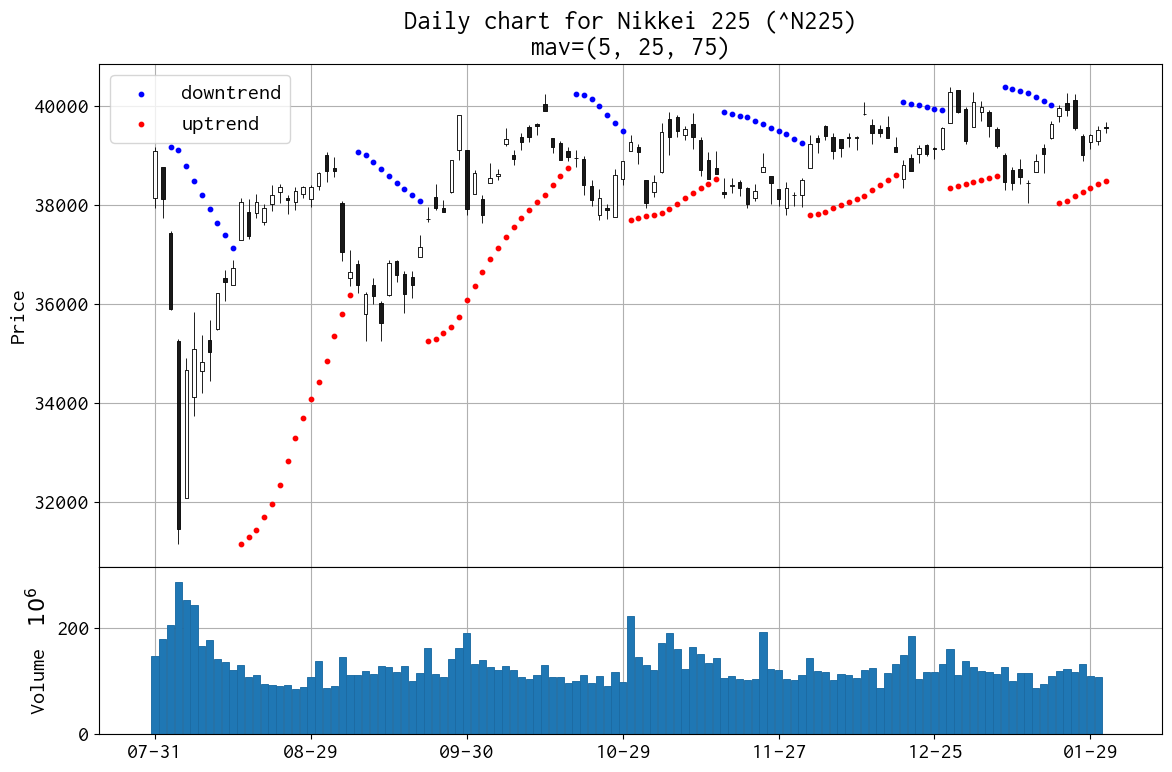

In [9]:
dict_psar = psar(df)

FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 8))
#ax = fig.add_subplot(111)
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[3 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=10,
        color='blue',
        label='downtrend',
        ax=ax[0]
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=10,
        color='red',
        label='uptrend',
        ax=ax[0]
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    volume=ax[1],
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax[0],
)
try:
    ax[0].set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax[0].set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

#ax.grid()

plt.tight_layout()
plt.savefig('daily_chart_n225.png')
plt.show()

In [4]:
df.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-01-31 00:00:00+09:00,39574.378906,39681.820312,39458.949219,39572.488281,0,0.0,0.0


In [5]:
df.tail(2)['Close']

Date
2025-01-30 00:00:00+09:00    39513.968750
2025-01-31 00:00:00+09:00    39572.488281
Name: Close, dtype: float64

In [6]:
df.tail(2)['Close'].diff()

Date
2025-01-30 00:00:00+09:00          NaN
2025-01-31 00:00:00+09:00    58.519531
Name: Close, dtype: float64

In [7]:
df['Close'].rolling(25).mean()

Date
2024-07-31 00:00:00+09:00             NaN
2024-08-01 00:00:00+09:00             NaN
2024-08-02 00:00:00+09:00             NaN
2024-08-05 00:00:00+09:00             NaN
2024-08-06 00:00:00+09:00             NaN
                                 ...     
2025-01-27 00:00:00+09:00    39287.098750
2025-01-28 00:00:00+09:00    39273.186406
2025-01-29 00:00:00+09:00    39286.509219
2025-01-30 00:00:00+09:00    39314.524844
2025-01-31 00:00:00+09:00    39349.348437
Name: Close, Length: 123, dtype: float64

In [8]:
df['Close'].rolling(75).mean()

Date
2024-07-31 00:00:00+09:00             NaN
2024-08-01 00:00:00+09:00             NaN
2024-08-02 00:00:00+09:00             NaN
2024-08-05 00:00:00+09:00             NaN
2024-08-06 00:00:00+09:00             NaN
                                 ...     
2025-01-27 00:00:00+09:00    39024.576875
2025-01-28 00:00:00+09:00    39029.660208
2025-01-29 00:00:00+09:00    39030.754115
2025-01-30 00:00:00+09:00    39038.439844
2025-01-31 00:00:00+09:00    39042.366875
Name: Close, Length: 123, dtype: float64